In [1]:
!nvidia-smi

Sun Apr  9 11:37:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

https://github.com/bnsreenu/python_for_microscopists/blob/master/076-077-078-Unet_nuclei_tutorial.py

In [2]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [3]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from keras.utils import normalize
from sklearn.model_selection import train_test_split

seed = 42
np.random.seed = seed

In [60]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
  #Build the model
  inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

  #Contraction path
  c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
  c1 = tf.keras.layers.Dropout(0.1)(c1)
  c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
  p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

  c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
  c2 = tf.keras.layers.Dropout(0.1)(c2)
  c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
  p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
  
  c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
  c3 = tf.keras.layers.Dropout(0.2)(c3)
  c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
  p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
  
  c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
  c4 = tf.keras.layers.Dropout(0.2)(c4)
  c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
  p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
  
  c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
  c5 = tf.keras.layers.Dropout(0.3)(c5)
  c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

  #Expansive path 
  u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
  u6 = tf.keras.layers.concatenate([u6, c4])
  c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
  c6 = tf.keras.layers.Dropout(0.2)(c6)
  c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
  
  u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
  u7 = tf.keras.layers.concatenate([u7, c3])
  c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
  c7 = tf.keras.layers.Dropout(0.2)(c7)
  c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
  
  u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
  u8 = tf.keras.layers.concatenate([u8, c2])
  c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
  c8 = tf.keras.layers.Dropout(0.1)(c8)
  c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
  
  u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
  c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
  c9 = tf.keras.layers.Dropout(0.1)(c9)
  c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
  
  outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
  
  model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  return model

In [17]:
!cp -r /content/drive/MyDrive/dent.zip -d /content
!unzip -q /content/dent.zip

In [18]:
SIZE = 256

image_path = '/content/dent/train/image'
mask_path = '/content/dent/train/label'

image_dataset = []
mask_dataset = []

In [19]:
images = os.listdir(image_path)
print('total images',len(images))

for i, image in enumerate(images):
  path = os.path.join(image_path,image)
  # img = cv2.imread(path,0)
  img = cv2.imread(path)
  img = cv2.resize(img,(SIZE,SIZE),interpolation = cv2.INTER_AREA)
  img = img/255.0
  image_dataset.append(img)

total images 41


In [20]:
masks = os.listdir(mask_path)
print('total masks',len(masks))

for i, mask in enumerate(masks):
  path = os.path.join(mask_path,mask)
  # img = cv2.imread(path,0)
  img = cv2.imread(path,0)
  img = cv2.resize(img,(SIZE,SIZE),interpolation = cv2.INTER_AREA)
  mask_dataset.append(img)

total masks 41


In [21]:
# image_dataset = np.expand_dims(normalize(np.array(image_dataset),axis=1),3)
image_dataset = np.array(image_dataset)
print(image_dataset.shape)

(41, 256, 256, 3)


In [22]:
mask_dataset = np.expand_dims((np.array(mask_dataset)),3)/255.
print(mask_dataset.shape)

(41, 256, 256, 1)


In [23]:
X_train,X_test,y_train,y_test = train_test_split(image_dataset,mask_dataset,test_size = 0.2)
print('X_train',X_train.shape)
print('X_test',X_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

X_train (32, 256, 256, 3)
X_test (9, 256, 256, 3)
y_train (32, 256, 256, 1)
y_test (9, 256, 256, 1)


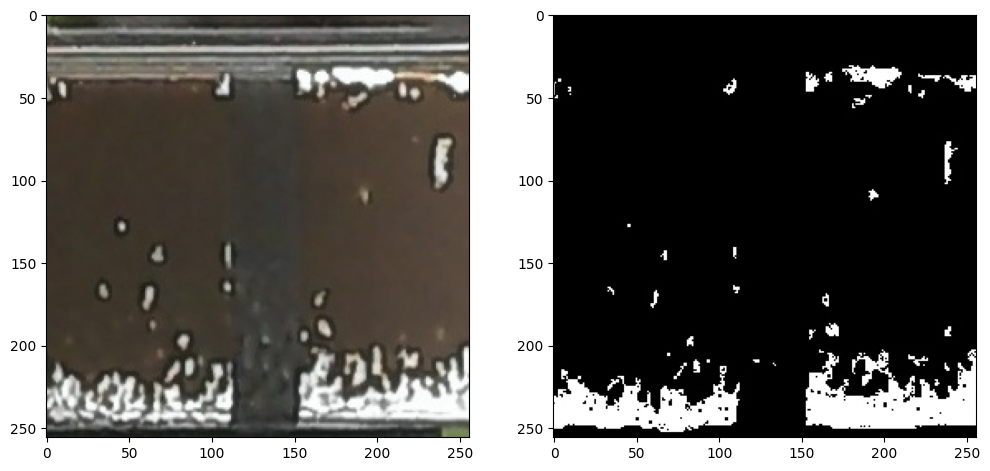

In [24]:
image_number = random.randint(0,len(X_train))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number],(256,256,3)),cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number],(256,256)),cmap='gray')

In [25]:
IMG_HEIGHT = SIZE
IMG_WIDTH = SIZE
IMG_CHANNELS = 3

In [26]:
model = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [52]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_1 (Lambda)              (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  448         ['lambda_1[0][0]']               
                                )                                                                 
                                                                                            

In [27]:
history = model.fit(X_train,y_train,
                    batch_size= 12,
                    verbose=2, # 0,1,2
                    epochs=400,
                    validation_data = (X_test,y_test),
                    shuffle=False
                    )

Epoch 1/400
3/3 - 27s - loss: 0.6903 - accuracy: 0.7767 - val_loss: 0.6816 - val_accuracy: 0.8918 - 27s/epoch - 9s/step
Epoch 2/400
3/3 - 0s - loss: 0.6742 - accuracy: 0.9076 - val_loss: 0.6428 - val_accuracy: 0.8918 - 435ms/epoch - 145ms/step
Epoch 3/400
3/3 - 1s - loss: 0.4962 - accuracy: 0.9059 - val_loss: 0.2756 - val_accuracy: 0.8916 - 513ms/epoch - 171ms/step
Epoch 4/400
3/3 - 0s - loss: 0.3168 - accuracy: 0.9067 - val_loss: 0.4115 - val_accuracy: 0.8918 - 459ms/epoch - 153ms/step
Epoch 5/400
3/3 - 0s - loss: 0.2747 - accuracy: 0.9073 - val_loss: 0.2572 - val_accuracy: 0.8918 - 446ms/epoch - 149ms/step
Epoch 6/400
3/3 - 1s - loss: 0.2469 - accuracy: 0.9075 - val_loss: 0.3401 - val_accuracy: 0.8918 - 547ms/epoch - 182ms/step
Epoch 7/400
3/3 - 0s - loss: 0.2391 - accuracy: 0.9076 - val_loss: 0.2575 - val_accuracy: 0.8918 - 398ms/epoch - 133ms/step
Epoch 8/400
3/3 - 0s - loss: 0.2231 - accuracy: 0.9076 - val_loss: 0.2847 - val_accuracy: 0.8918 - 496ms/epoch - 165ms/step
Epoch 9/400


In [33]:
# evaluate the model
_,acc = model.evaluate(X_test,y_test)
print('Accuracy=',(acc*100.0),'%')

1/1 [==============================] - 0s 59ms/step - loss: 0.1536 - accuracy: 0.9164
Accuracy= 91.63631796836853 %


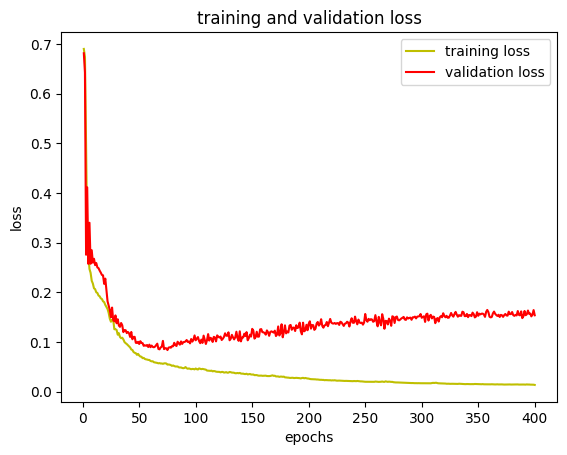

In [34]:
# plot the training and validation accuracy an loss each epochs
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs =range(1,len(loss)+1)
plt.plot(epochs,loss,'y',label='training loss')
plt.plot(epochs,val_loss,'r',label='validation loss')
plt.title('training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

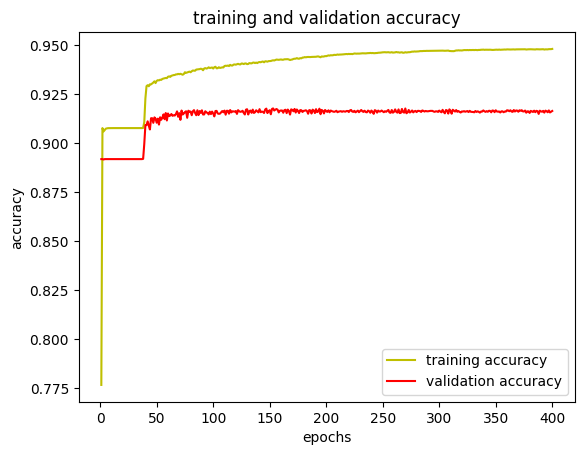

In [35]:
# plot the training and validation accuracy an loss each epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs =range(1,len(loss)+1)
plt.plot(epochs,acc,'y',label='training accuracy')
plt.plot(epochs,val_acc,'r',label='validation accuracy')
plt.title('training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [36]:
#IOU
y_pred = model.predict(X_test)
y_pred_thresholded = y_pred > 0.3

intersection = np.logical_and(y_test,y_pred_thresholded)
union = np.logical_or(y_test,y_pred_thresholded)
iou_score = np.sum(intersection)/np.sum(union)
print('IoU score is',iou_score)

1/1 [==============================] - 0s 26ms/step
IoU score is 0.45222831868316443


(256, 256, 3)
(256, 256, 1)
(1, 256, 256, 3)
1/1 [==============================] - 0s 27ms/step
(256, 256, 1)


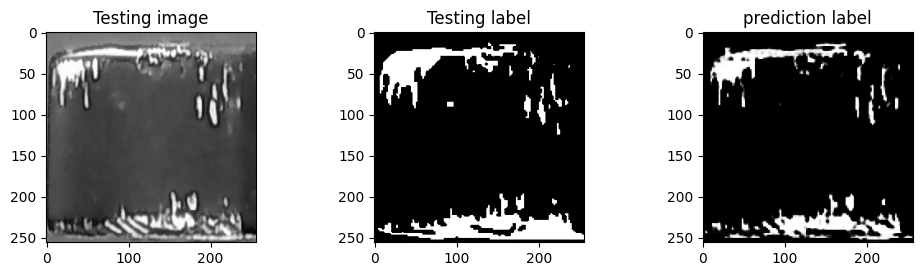

In [37]:
test_img_number = random.randint(0,len(X_test)-1)
test_img = X_test[test_img_number]
print(test_img.shape)
ground_truth = y_test[test_img_number]
print(ground_truth.shape)
test_img_input = np.expand_dims(test_img,0)
print(test_img_input.shape)
prediction = model.predict(test_img_input)[0]
print(prediction.shape)

plt.figure(figsize=(12,6))
plt.subplot(231)
plt.title('Testing image')
plt.imshow(test_img[:,:,0],cmap='gray')
plt.subplot(232)
plt.title('Testing label')
plt.imshow(ground_truth[:,:,0],cmap='gray')
plt.subplot(233)
plt.title('prediction label')
plt.imshow(prediction,cmap='gray')

In [41]:
# save model
model.save("model.hdf5")

# Load model and predict

In [97]:
# my_model = simple_unet_model(None, None,3)
my_model = simple_unet_model(SIZE, SIZE,3)
my_model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_15 (Lambda)             (None, 256, 256, 3)  0           ['input_16[0][0]']               
                                                                                                  
 conv2d_267 (Conv2D)            (None, 256, 256, 16  448         ['lambda_15[0][0]']              
                                )                                                                 
                                                                                           

In [99]:
my_model.load_weights('/content/model.hdf5')

In [100]:
large_image = cv2.imread('/content/img_min_right.jpg')
# large_image = large_image/255
# large_image = np.expand_dims(large_image,0)
print(large_image.shape)

(218, 3606, 3)


In [139]:
patch_size =256

def prediction(model, image, patch_size):
  H,W,c = image.shape
  segm_img = np.zeros(image.shape[:2])  #Array with zeros to be filled with segmented values
  patch_num=1
  for i in range(0, image.shape[0], 256):   #Steps of 256
      for j in range(0, image.shape[1], 256):  #Steps of 256
          print(i, j)
          single_patch = image[i:i+patch_size, j:j+patch_size]
          single_patch_shape = single_patch.shape
          print(single_patch_shape)
          single_patch = cv2.resize(single_patch,(patch_size,patch_size), interpolation = cv2.INTER_AREA)
          single_patch_norm = single_patch /255.0
          single_patch_input = np.expand_dims(single_patch_norm, 0)
          #single_patch_prediction = (model.predict(single_patch_input)[0,:,:,0] > 0.5).astype(np.uint8)
          single_patch_prediction = model.predict(single_patch_input)[0]
          print(single_patch_prediction.shape)
          single_patch_prediction = cv2.resize(single_patch_prediction,(single_patch_shape[1],single_patch_shape[0]),interpolation=cv2.INTER_AREA)
          print(single_patch_prediction.shape)
          segm_img[i:i+single_patch_shape[0], j:j+single_patch_shape[1]] += single_patch_prediction
        
          print("Finished processing patch number ", patch_num, " at position ", i,j)
          patch_num+=1
  return segm_img

In [142]:
large_prediction = prediction(model,large_image,patch_size)
print(large_prediction.shape)

0 0
(218, 256, 3)
1/1 [==============================] - 0s 34ms/step
(256, 256, 1)
(218, 256)
Finished processing patch number  1  at position  0 0
0 256
(218, 256, 3)
1/1 [==============================] - 0s 35ms/step
(256, 256, 1)
(218, 256)
Finished processing patch number  2  at position  0 256
0 512
(218, 256, 3)
1/1 [==============================] - 0s 39ms/step
(256, 256, 1)
(218, 256)
Finished processing patch number  3  at position  0 512
0 768
(218, 256, 3)
1/1 [==============================] - 0s 47ms/step
(256, 256, 1)
(218, 256)
Finished processing patch number  4  at position  0 768
0 1024
(218, 256, 3)
1/1 [==============================] - 0s 53ms/step
(256, 256, 1)
(218, 256)
Finished processing patch number  5  at position  0 1024
0 1280
(218, 256, 3)
1/1 [==============================] - 0s 35ms/step
(256, 256, 1)
(218, 256)
Finished processing patch number  6  at position  0 1280
0 1536
(218, 256, 3)
1/1 [==============================] - 0s 32ms/step
(256, 256

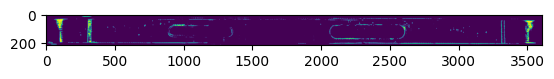

In [143]:
plt.imshow(large_prediction)

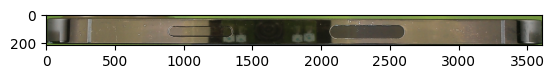

In [144]:
plt.imshow(large_image)